# HMT CODE FILE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir(r'/content/drive/My Drive/ECE1512_TA')  # Change the directory to torchRay-master folder

# Requirements

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [22]:
# train_dir = '/content/drive/My Drive/ECE1512_TA/hmt_dataset/HMT_train'
# test_dir = '/content/drive/My Drive/ECE1512_TA/hmt_dataset/HMT_test'

train_dir = 'hmt_dataset/HMT_train'
test_dir = 'hmt_dataset/HMT_test'



train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [23]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

# Training

In [25]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [26]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [8]:
# model.fit_generator(generator=train_generator,
#                     steps_per_epoch=train_generator.n // 32,
#                     epochs=150,
#                     callbacks=[tensorboard_cb],                  
#                     shuffle = True,
#                     verbose=1)

In [9]:
#model.save('HMT.h5')

# Load Model

In [27]:
model=load_model('models/HMT.h5')

In [28]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'log/train'

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

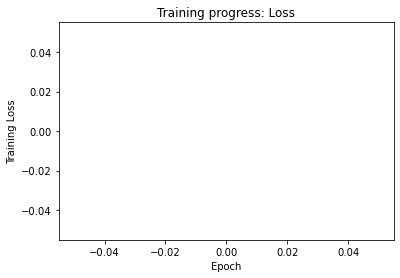

In [29]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Task #3: Biomedical image classification and interpretation

1. Performance Metrics

In [30]:
# Importing additional libraries we will need for the project

from sklearn import metrics
from sklearn.metrics import recall_score, classification_report, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, f1_score

from sklearn.datasets import make_classification
import tensorflow as tf
from tensorflow import metrics
from sklearn.metrics import confusion_matrix 
import random
import seaborn as sns

In [40]:
y_predictions = model.predict_generator(test_generator)

In [41]:
#print(y_predictions)
y_classes = np.argmax(y_predictions, axis = 1)
print(y_classes)

[0 0 0 0 2 0 0 0 0 0 0 0 0 3 0 5 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 1 1 2 1 2 1 1 1 1 1 1 1
 1 1 1 1 4 1 1 1 2 1 1 1 1 1 1 1 1 4 1 1 1 1 2 4 1 1 4 1 1 1 4 1 1 1 4 4 1
 1 1 4 4 1 1 1 1 5 1 2 1 1 2 2 2 2 2 2 4 2 2 2 4 2 2 1 2 2 1 2 1 2 2 1 2 2
 2 1 2 2 2 2 2 2 1 1 2 2 2 3 2 2 2 2 3 2 2 2 1 2 2 2 2 2 2 2 2 1 1 2 2 2 2
 2 2 3 3 3 3 3 3 3 2 3 3 3 3 3 2 3 3 3 3 2 3 3 3 2 3 3 3 3 3 0 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 3 3 3 0 3 3 1 1 5 1 4 4 1 4 4 1 1
 1 1 4 4 1 4 4 4 1 4 4 4 4 4 1 4 4 4 4 4 1 4 4 4 1 4 1 4 4 1 4 4 4 4 4 1 4
 4 1 4 1 4 4 4 4 1 4 4 4 4 1 5 5 5 5 5 5 5 5 4 2 5 5 5 5 5 5 5 5 5 5 5 5 4
 5 5 5 5 5 5 2 5 5 0 3 5 5 0 5 5 2 5 5 5 5 5 5 5 2 4 5 5 5 5 5 5 2 5 5 5 5
 5 5 6 6 7 7 6 6 6 6 6 6 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 

In [42]:
# True Labels
true_classes = test_generator.classes
print(true_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 

In [43]:
class_labels=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']
class_labels_dict={0: 'Tumor',
                   1: 'Stroma',
                   2: 'Complex',
                   3: 'Lympho',
                   4: 'Debris',
                   5: 'Mucosa',
                   6: 'Adiopse',
                   7: 'Empty'}

In [44]:
# THIS CODE IS FROM MY M.ENG PROJECT TO BE IGNORED

# from sklearn import metrics
# test_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)

# predictions = model.predict_generator(validation_generator, steps=test_steps_per_epoch)
# # Get most likely class
# predicted_classes = np.argmax(predictions, axis=1)


# class_labels = list(validation_generator.class_indices.keys()) 

# report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report) 

In [45]:
y_test = true_classes
y_predict_class = y_classes

# Question a. What is the overall accuracy on the test set?

In [46]:
print("Accuracy Score for the model: ", accuracy_score(y_test, y_predict_class))

Accuracy Score for the model:  0.8346774193548387


## Question b. What is the class-wise classification accuracy for all the classes

we will use the confusion matrix to calculate the classwise accuracy

In [47]:
normalize_confusion_matrix = confusion_matrix(y_test, y_predict_class, normalize = 'true') 
print(normalize_confusion_matrix)

[[0.85483871 0.         0.11290323 0.01612903 0.         0.01612903
  0.         0.        ]
 [0.         0.75806452 0.08064516 0.         0.14516129 0.01612903
  0.         0.        ]
 [0.         0.16129032 0.77419355 0.03225806 0.03225806 0.
  0.         0.        ]
 [0.03225806 0.         0.11290323 0.85483871 0.         0.
  0.         0.        ]
 [0.         0.32258065 0.         0.         0.66129032 0.01612903
  0.         0.        ]
 [0.03225806 0.         0.08064516 0.01612903 0.0483871  0.82258065
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.9516129  0.0483871 ]
 [0.         0.         0.         0.         0.         0.
  0.         1.        ]]


# Question d. Plot the normalized confusion Matrix

Text(0.5, 1.0, ' Confusion Matrix for MNIST-1D Dataset')

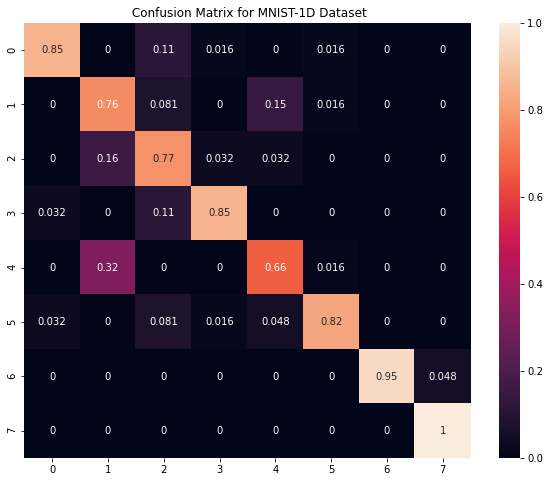

In [48]:
plt.figure(figsize=(10,8))
sns.heatmap(normalize_confusion_matrix,  annot=True)

plt.title(" Confusion Matrix for MNIST-1D Dataset")

In [49]:
y_predict_class2 = np.expand_dims(y_predict_class, axis=-1) 

y_test2 = np.expand_dims(y_test, axis=-1) 


In [50]:
y_test2.shape

(496, 1)

In [51]:
print("Area Under the ROC curve: ", roc_auc_score(y_test2, y_predictions, multi_class = 'ovr'))

Area Under the ROC curve:  0.9839313587037313


## Question c. Plot ROC and AUC for each class

Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [52]:
from sklearn.preprocessing import label_binarize
from scipy import interp

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

In [53]:
# One hot encoding the the prediction vector using label binarizing method
y_predict_roc = label_binarize(y_predict_class, classes=[0, 1, 2,3,4,5,6,7,8,9])
y_predict_roc

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [54]:
# One hot encoding the the test vector using label binarizing method

y_test_roc = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])

In [55]:
# Now calculating the ROC curve for each class
# Total number of classes
n_classes = 8

# Define a dictionary for flase
false_positives= {}
true_positives = {}
roc_auc = {}

for i in range(n_classes):
    false_positives[i], true_positives[i], _ = roc_curve(y_test_roc[:, i], y_predictions[:, i])
    #print("FPR :",false_positives[i],"TPR:", true_positives[i]," Threshold:", _)
    
    # Computing AUC for each class ROC curve
    roc_auc[i] = auc(false_positives[i], true_positives[i])
    #print("shape:", y_test_roc[:, i].shape)

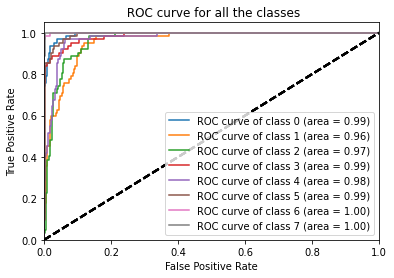

In [56]:

colors = cycle(['aqua', 'goldenrod', 'cornflowerblue','tomato','magenta'])

for i in range(n_classes):
    plt.plot(false_positives[i], true_positives[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve for class {}'.format(i))
    plt.legend(loc="lower right")
plt.title(" ROC curve for all the classes")
plt.show()

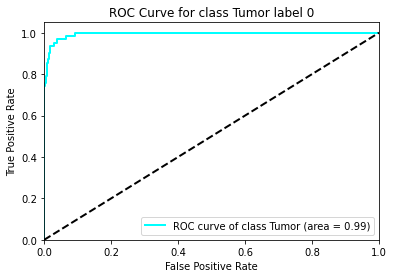

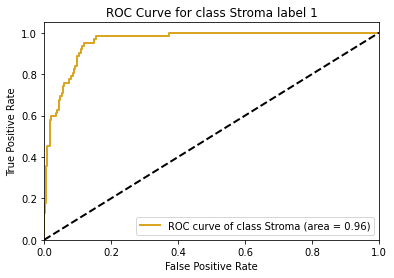

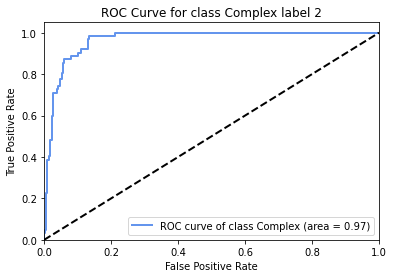

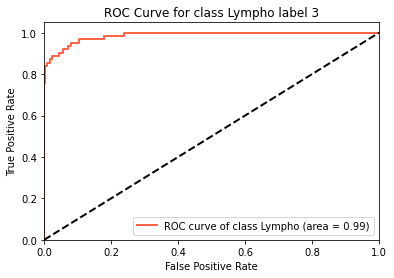

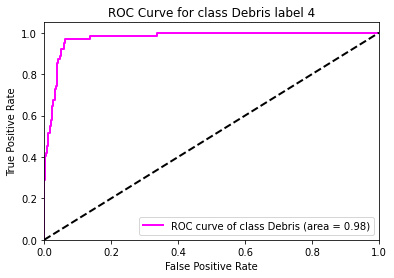

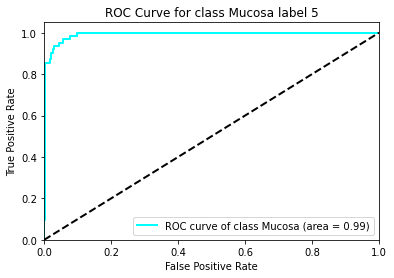

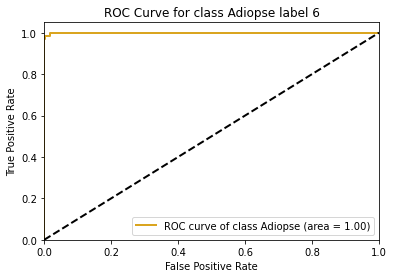

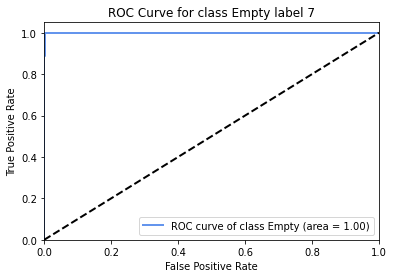

In [57]:
for i, color in zip(range(n_classes), colors):
    plt.plot(false_positives[i], true_positives[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels_dict[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for class {} label {}'.format(class_labels_dict[i], i))
    plt.legend(loc="lower right")
    plt.show()

## Question e. Find Precision, Recall and F-1 Score fo test set

In [58]:
# Looking at the classification report for the test set
print(classification_report(true_classes, y_classes, target_names = class_labels))

              precision    recall  f1-score   support

       Tumor       0.93      0.85      0.89        62
      Stroma       0.61      0.76      0.68        62
     Complex       0.67      0.77      0.72        62
      Lympho       0.93      0.85      0.89        62
      Debris       0.75      0.66      0.70        62
      Mucosa       0.94      0.82      0.88        62
     Adiopse       1.00      0.95      0.98        62
       Empty       0.95      1.00      0.98        62

    accuracy                           0.83       496
   macro avg       0.85      0.83      0.84       496
weighted avg       0.85      0.83      0.84       496



## Looking at overall precision, recall and F-1 Score

In [59]:
# Calculating Recall
print("Recall for the Test Set: ", recall_score(y_test, y_predict_class, average = 'micro'))

Recall for the Test Set:  0.8346774193548387


In [60]:
# Calculating F1-Score
print("F1-Score for the Test Set: ", f1_score(y_test, y_predict_class, average = 'micro'))

F1-Score for the Test Set:  0.8346774193548387


In [61]:
# Calculating Precision
print("Precision for the Test Set: ", precision_score(y_test, y_predict_class, average = 'micro'))

Precision for the Test Set:  0.8346774193548387


# Task 1 Question 2 part a)


In [62]:
test_datagen2 = ImageDataGenerator(rescale=1/255.)


test_generator2 = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=y_predict_class.shape[0],
shuffle=False)




test_generator2.reset()

image_batch2,label_batch2=test_generator2.next()

Found 496 images belonging to 8 classes.


In [63]:
# getting the index of correct and incorrect predictions
incorrect_index = []
correct_index = []
for i in range(y_predict_class.shape[0]):
    if y_test[i] == y_predict_class[i]:
        correct_index.append(i)
    else:
        incorrect_index.append(i)
    


In [64]:

index = random.choice(incorrect_index) 

In [65]:
# looking at some correct and incorrect predictions for the model
def prediction_plot(index):
    plt.figure(figsize=(20,5))
    
    image = image_batch2[index]
    label = y_test[index]
              
    print("Index: ",index)
    print('Correct label: '+class_labels_dict[label])
    predicted_label = np.argmax(model(np.expand_dims(image, axis=0)))
    print('Predicted label: '+ class_labels_dict[predicted_label])
    print('Confidence score for the correct label: '+str(model(np.expand_dims(image, axis=0)).numpy()[0,label]))
    
    plt.subplot(1,4,1)
    plt.imshow(image_batch2[index])
    plt.axis('off')
    plt.title('Input image')
    plt.show()
    
    
    


    return

Index:  332
Correct label: Mucosa
Predicted label: Debris
Confidence score for the correct label: 0.28725612


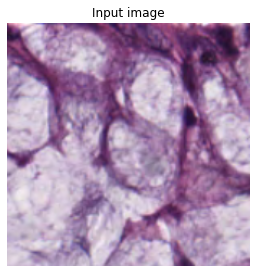

In [66]:
index2 = random.choice(incorrect_index)
prediction_plot(index2)


Index:  119
Correct label: Stroma
Predicted label: Mucosa
Confidence score for the correct label: 0.30971262


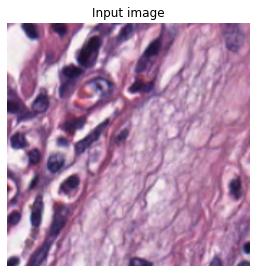

In [67]:
index2 = random.choice(incorrect_index)
prediction_plot(index2)



Index:  149
Correct label: Complex
Predicted label: Stroma
Confidence score for the correct label: 0.43054715


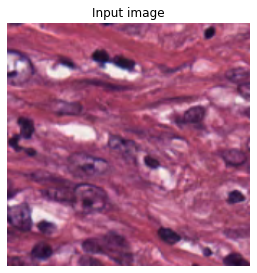

In [68]:
index2 = random.choice(incorrect_index)
prediction_plot(index2)


Index:  128
Correct label: Complex
Predicted label: Complex
Confidence score for the correct label: 0.85231274


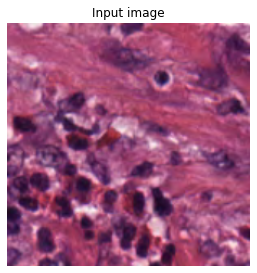

In [69]:
index2 = random.choice(correct_index)
prediction_plot(index2)


Index:  218
Correct label: Lympho
Predicted label: Lympho
Confidence score for the correct label: 0.99998057


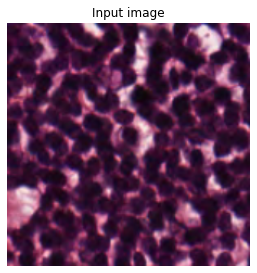

In [70]:
index2 = random.choice(correct_index)
prediction_plot(index2)


Index:  335
Correct label: Mucosa
Predicted label: Mucosa
Confidence score for the correct label: 0.8602985


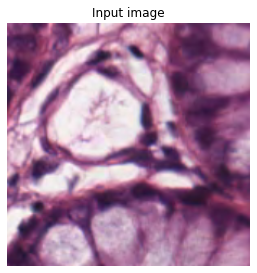

In [71]:
index2 = random.choice(correct_index)
prediction_plot(index2)


# Explanation

Load the explaier library

In [72]:
from xai_utils import *

Load a batch of images

In [73]:
test_generator.reset()

In [74]:
image_batch,label_batch=test_generator.next()

Classes:

In [75]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [76]:
index=8

In [77]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9661708


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [78]:
layers=[['conv2d_3']]

In [79]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

Wall time: 862 ms


## Grad-CAM (Gradient-based Class Activation Mapping)

In [80]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

Wall time: 310 ms


## RISE (Randomized Input Sampling for Explanation)

In [81]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

Wall time: 10.4 s


## Plot the results

Text(0.5, 1.0, 'Explanation map (RISE)')

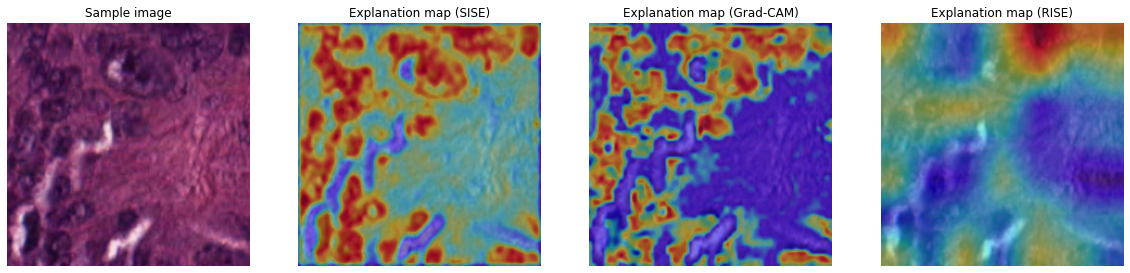

In [82]:
#@title Plot the results

plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,4,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(1,4,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

plt.subplot(1,4,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)')

## Quantitative evaluation of the explanation algorithm

In [83]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [84]:
test_generator.reset()
drop_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[0]
drop_rate /= (15*32)

KeyboardInterrupt: 

In [ ]:
drop_rate
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)


# Grad-Cam++

In [85]:

import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt

from tensorflow.keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions


from PIL import Image

### Below is an extra dataset that I have defined just to check GradCAM. Please Comment this out when running on your own machine

In [86]:

files = os.listdir('GradCam_dataset')
print(files[0])

path = os.path.join("GradCam_dataset/",files[0])

#print(path)
orig_img = np.array(load_img(path,target_size=(224,224)),dtype=np.uint8)
img = np.array(load_img(path,target_size=(224,224)),dtype=np.float64)
#img = Image.open(path)
img = img/255.

img = np.expand_dims(img,axis=0)
#print("Image shape:",img.shape)
#plt.imshow(img)
# plt.show()
print("Image shape:",img.shape)
#plt.imshow(img)
# plt.show()
predictions = model.predict(img)

11681_CRC-Prim-HE-09_002.tif_Row_151_Col_151.tif
Image shape: (1, 224, 224, 3)


# GradCAM++
reference: https://github.com/adityac94/Grad_CAM_plus_plus/blob/master/misc/utils.py

In [87]:
# defining a gradcam function to calculate gradient - saliency map and implement the funciton.

def gradCamPlusPlus(input_model, image, conv_layer, label_name = None, category_id = None):
    '''
    input_model: This is the input we will be working with
    image: this the image we want the gradient too
    conv_layers: This is the name of the last convulation layer in our model
    label_name: Name of the label
    Category_id: is the class that the prediction belongs to
    
    '''
    
    

    # Defining the image tensor fromt he input image
    img_tensor = image
        
    # Getting the convolution layer to which we want to compute dervative
    conv_layer = input_model.get_layer(conv_layer)
    model_heatmap = Model([input_model.inputs], [conv_layer.output, input_model.output])
    
#     print(model_heatmap)

    # Defining gradient tape in tensorflow to take 1st, 2nd and thrid derivative
    with tf.GradientTape() as g1:
        with tf.GradientTape() as g2:
            with tf.GradientTape() as g3:
                                
                #getting prediction and output for conv layer and final class
                conv_output, predictions = model_heatmap(img_tensor)
#                 print("predictions:", predictions)

                if category_id==None:
#                     print("No Category ID given!","\n")
                    category_id = np.argmax(predictions)
    
                if label_name:
                    print("Class with highest probability: ",class_labels_dict[category_id],"\n")
                
#                 print(category_id)
                #getting the final output
                output = predictions[:, category_id]
#                 print(output.shape)
                
                conv_first_grad = g3.gradient(output, conv_output)
                
            conv_second_grad = g2.gradient(conv_first_grad, conv_output)
            
        conv_third_grad = g1.gradient(conv_second_grad, conv_output)
    
#     print("conv output shape:", conv_output.shape,"\n")
#     print("conv 1 grad shape:", conv_first_grad.shape,"\n")
#     print("conv 2 grad shape:", conv_second_grad[0].shape,"\n")
#     print("conv 3 grad shape:", conv_third_grad.shape,"\n")
    
    
    global_sum = np.sum(conv_output, axis=(0, 1, 2))
#     print("Global Sum shape:", global_sum.shape,"\n")
    # Calculating Alpha value
    
    alpha_num = conv_second_grad[0]
    alpha_denom = np.multiply(conv_second_grad[0],2.0) + np.multiply(conv_third_grad[0],global_sum)
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    alphas = np.divide(alpha_num,alpha_denom)
    
#     print("alphas shape:", alphas.shape)
    
    # Normalizing our Alpha Value 
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant
#     print('Normalized alpha: ', alpha_normalization_constant.shape)
    
    # Calculating the gradient for weights
    weights = np.maximum(conv_first_grad[0], 0.0)
#     print("Weights shape: ",weights.shape)
    
#     _ = (weights*alphas)
# #     print("_: ", _.shape)
#     _ = np.reshape(_,(-1,conv_first_grad[0].shape[2]))
# #     print("_: ", _.shape)
#     _ = np.sum(_,axis = 0)
# #     print("_: ", _.shape)
    
    # getting final weights
    deep_linearization_weights = np.sum((weights*alphas),axis=(0,1))
    
#     print("deep_linearization_weights",deep_linearization_weights.shape,"\n")
    
#     _ = (deep_linearization_weights*conv_output[0])
#     print("_: ", _.shape)
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    CAM_map = np.maximum(grad_CAM_map, 0)
#     print("Heatmap shape: ",CAM_map.shape)
    max_heat = np.max(CAM_map)
    if max_heat == 0:
        max_heat = 1e-10
    CAM_map /= max_heat

    return CAM_map

In [88]:
# TESTING 
gradcamplus=gradCamPlusPlus(model,img ,conv_layer='max_pooling2d_1')


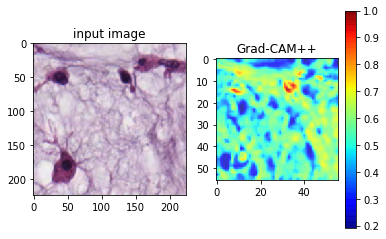

In [89]:
fig, ax = plt.subplots(nrows=1,ncols=2)
plt.subplot(121)
plt.imshow(orig_img)
plt.title("input image")

plt.subplot(122)
#plt.imshow(orig_img)
plt.imshow(gradcamplus,alpha=0.8,cmap="jet")
plt.title("Grad-CAM++")
plt.colorbar()
plt.show()

In [90]:
# model.summary()

In [91]:
from keras.preprocessing.image import img_to_array, load_img, array_to_img

Image shape: (1, 224, 224, 3)
Predicted Label:  4


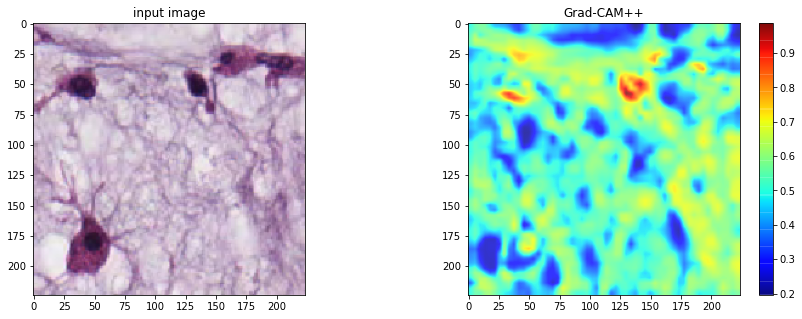

Image shape: (1, 224, 224, 3)
Predicted Label:  2


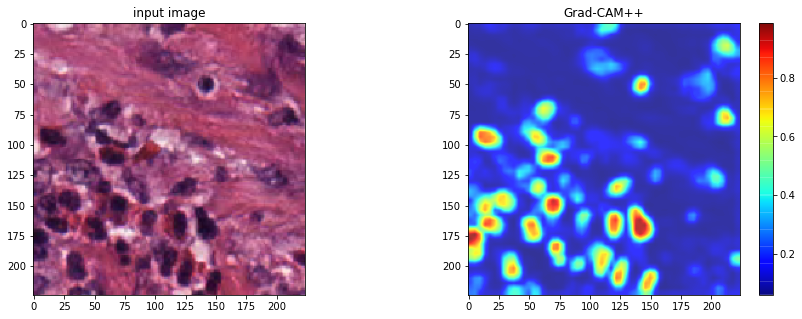

Image shape: (1, 224, 224, 3)
Predicted Label:  2


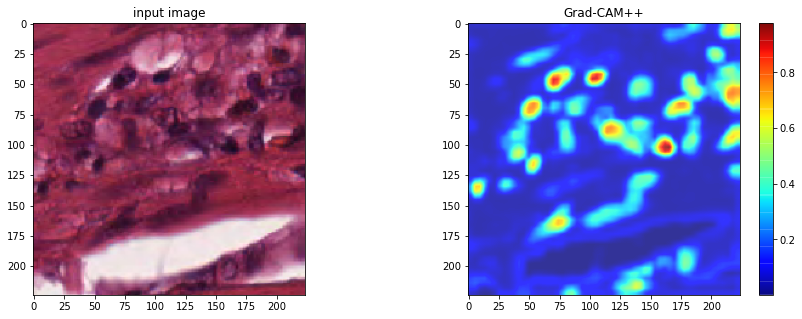

Image shape: (1, 224, 224, 3)
Predicted Label:  3


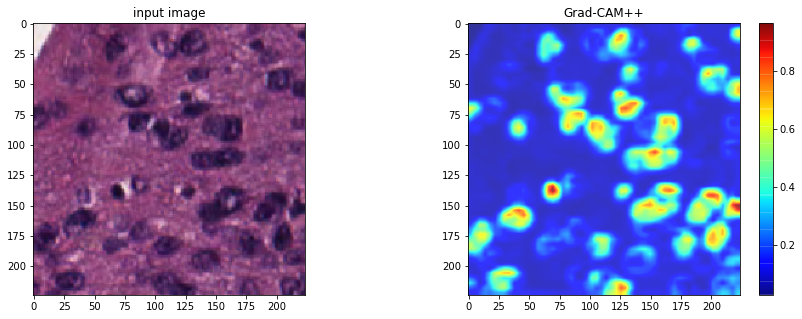

Image shape: (1, 224, 224, 3)
Predicted Label:  5


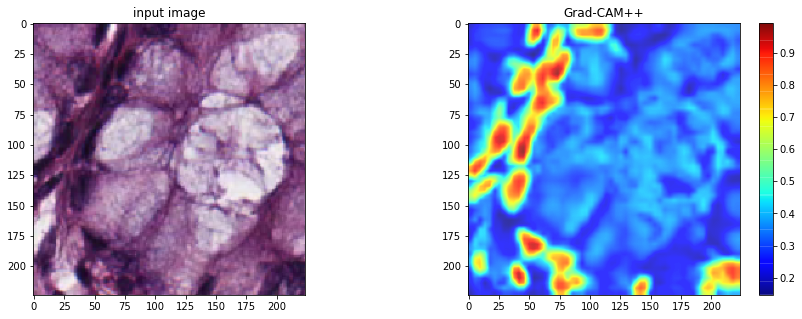

Image shape: (1, 224, 224, 3)
Predicted Label:  6


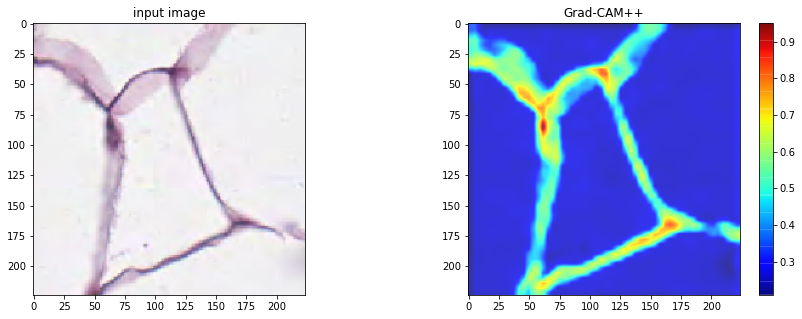

Image shape: (1, 224, 224, 3)
Predicted Label:  7


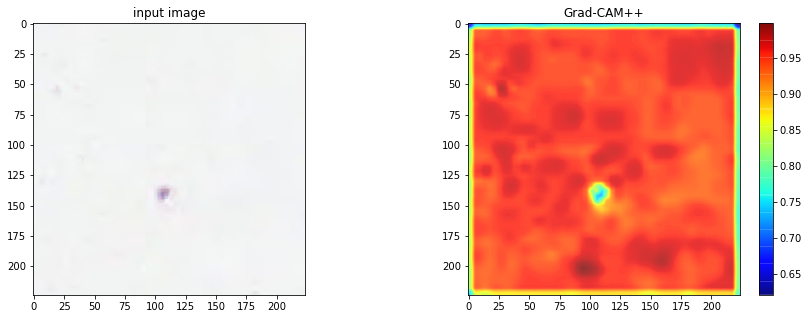

Image shape: (1, 224, 224, 3)
Predicted Label:  3


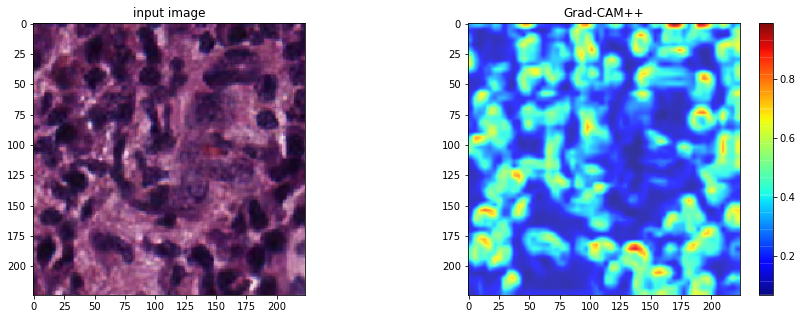

In [93]:
# COMMENT THIS OUT AS IT RUNS ON THE EXTRA DATASET I HAVE DEFINDED to see results from different classes
for f in files:
    path = os.path.join("GradCam_dataset/",f)
   
    #print(path)
    orig_img = np.array(load_img(path,target_size=(224,224)),dtype=np.uint8)
    img = np.array(load_img(path,target_size=(224,224)),dtype=np.float64)
    #img = Image.open(path)
    img = img/255.
    img = np.expand_dims(img,axis=0)
#     plt.imshow(image_batch[index])
    
    print("Image shape:",img.shape)
    predictions = model.predict(img)
    print("Predicted Label: ", np.argmax(predictions))
    
    gradcam_plusplus=gradCamPlusPlus(model,img ,conv_layer='max_pooling2d_1')
    gradcam_ = grad_cam(model, img, 'max_pooling2d_1')
    
    gradcam_plusplus = cv2.resize(gradcam_plusplus, (224,224))
    gradcam_ = cv2.resize(gradcam_, (224,224))
    

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize = (15,5))
    plt.subplot(121)
    plt.imshow(orig_img)
    plt.title("input image")

    plt.subplot(122)
    plt.imshow(gradcam_plusplus,alpha=0.8,cmap="jet")
    plt.title("Grad-CAM++")
    plt.colorbar()
    
#     plt.subplot(133)
#     plt.imshow(gradcam_,alpha=0.8,cmap="jet")
#     plt.title("Grad-CAM")
#     plt.colorbar()
    plt.show()

## Checking GradCAM++ Exploratin maps and comapring them with GradCAM

Index:  270
Correct digit: 4
Predicted digit: 4
Confidence score for the correct label: 0.9165269


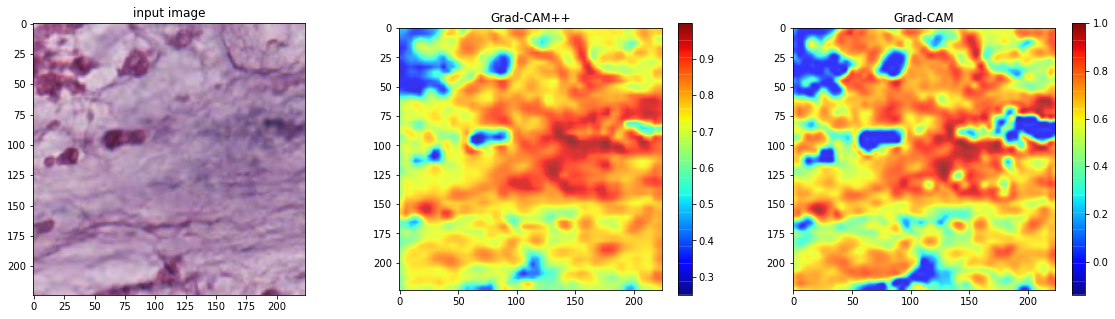

Index:  75
Correct digit: 1
Predicted digit: 1
Confidence score for the correct label: 0.38001096


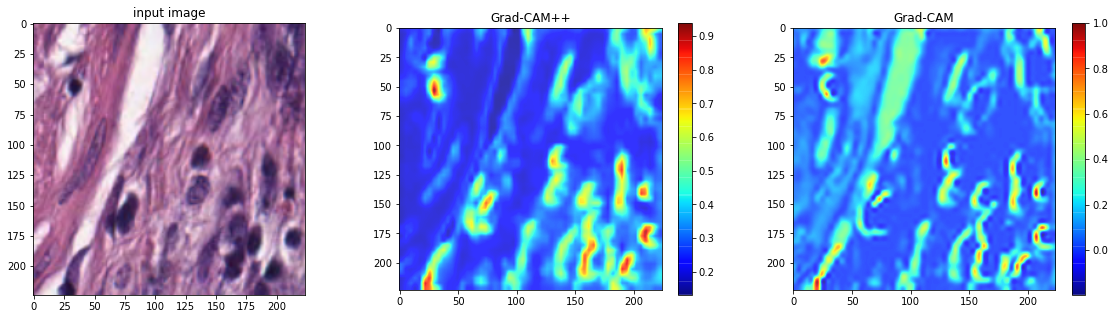

Index:  415
Correct digit: 6
Predicted digit: 6
Confidence score for the correct label: 0.94489855


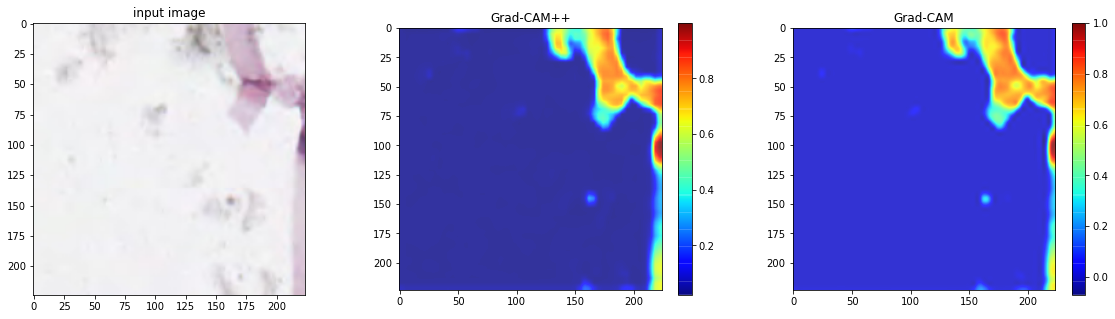

Index:  102
Correct digit: 1
Predicted digit: 1
Confidence score for the correct label: 0.5920449


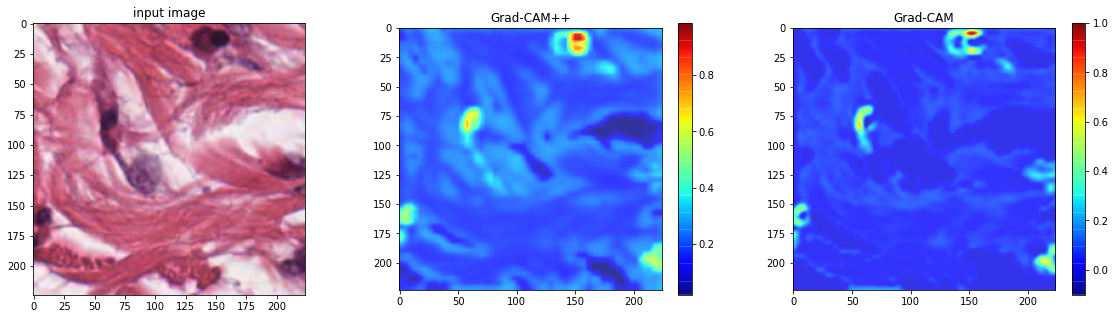

Index:  41
Correct digit: 0
Predicted digit: 0
Confidence score for the correct label: 0.988003


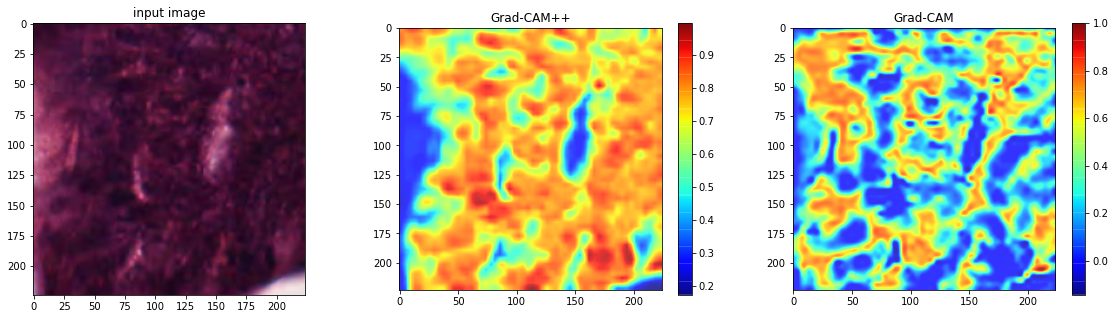

Index:  11
Correct digit: 0
Predicted digit: 0
Confidence score for the correct label: 0.9995468


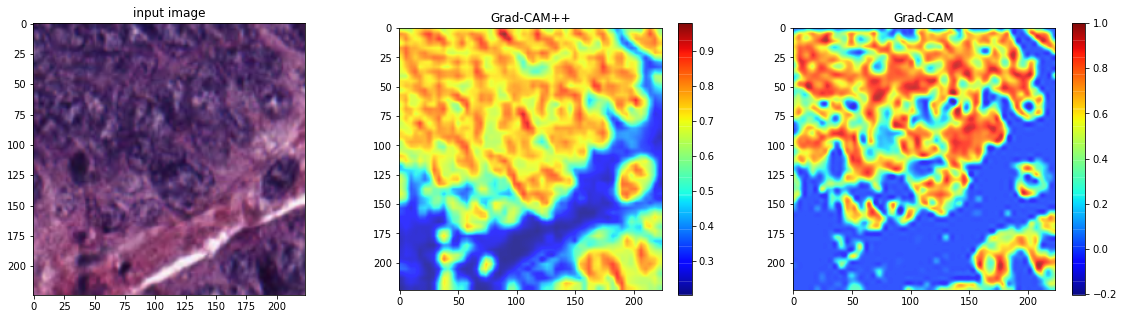

Index:  115
Correct digit: 1
Predicted digit: 1
Confidence score for the correct label: 0.6362781


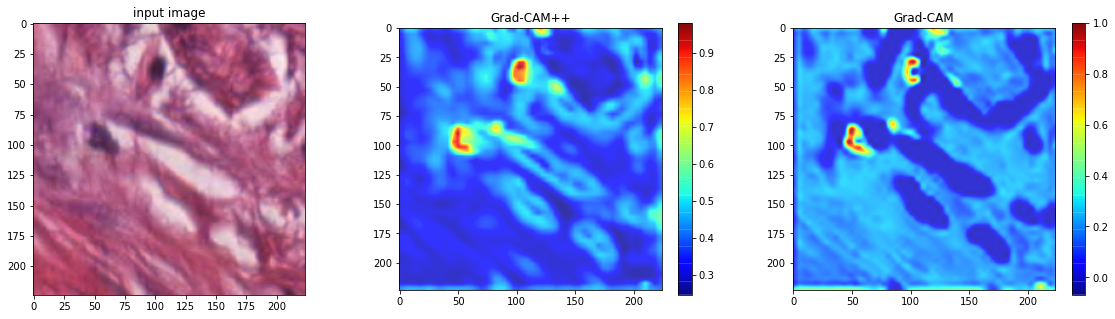

Index:  93
Correct digit: 1
Predicted digit: 1
Confidence score for the correct label: 0.67855996


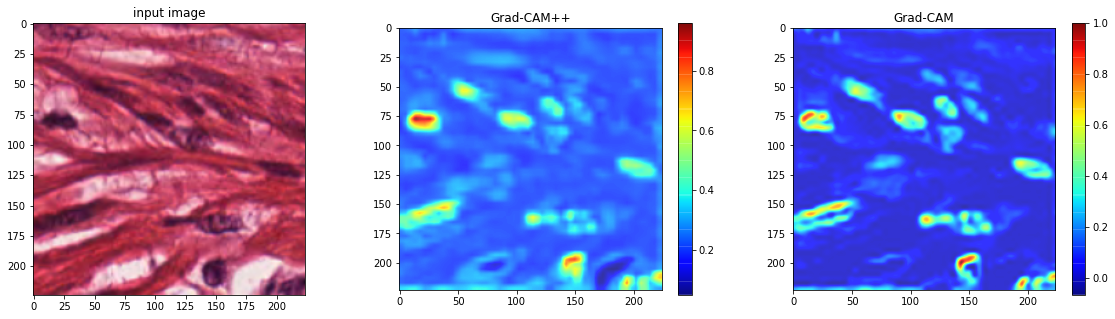

Index:  300
Correct digit: 4
Predicted digit: 4
Confidence score for the correct label: 0.92494905


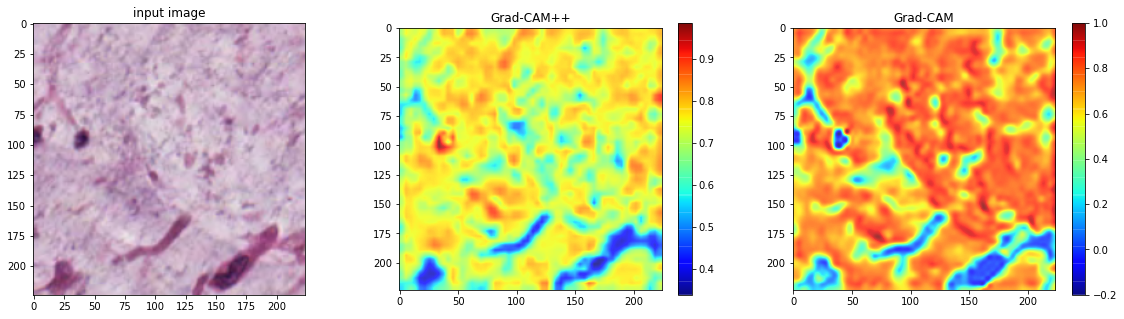

Index:  207
Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 0.9826848


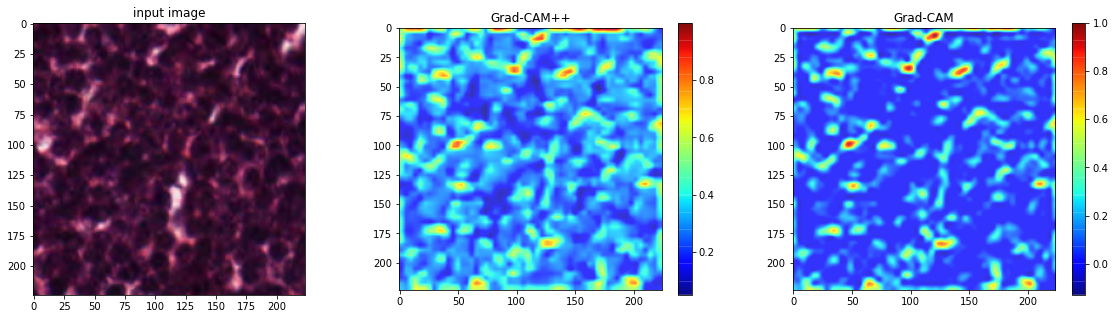

In [99]:
for i in range (10):
    index2 = random.choice(correct_index) 
    image2 = image_batch2[index2]
    label = y_test[index2]
    img2 = np.expand_dims(image2,axis=0)          
    print("Index: ",index2)
    print('Correct digit: '+str(label))
    predicted_label = np.argmax(model(np.expand_dims(image2, axis=0)))
    print('Predicted digit: '+str(predicted_label))
    print('Confidence score for the correct label: '+str(model(np.expand_dims(image2, axis=0)).numpy()[0,label]))
    
    # Getting exploration maps
    gradcam_plusplus=gradCamPlusPlus(model,img2 ,conv_layer='max_pooling2d_1')
    gradcam_ = grad_cam(model, img2, 'max_pooling2d_1')
    # resizing to input image size
    gradcam_plusplus = cv2.resize(gradcam_plusplus, (224,224))
    gradcam_ = cv2.resize(gradcam_, (224,224))
    
    # Plotting 
    fig, ax = plt.subplots(nrows=1,ncols=3, figsize = (20,5))
    plt.subplot(131)
    plt.imshow(image2)
    plt.title("input image")

    plt.subplot(132)
    plt.imshow(gradcam_plusplus,alpha=0.8,cmap="jet")
    plt.title("Grad-CAM++")
    plt.colorbar()
#     plt.show()

    
    plt.subplot(133)
    plt.imshow(gradcam_,alpha=0.8,cmap="jet")
    plt.title("Grad-CAM")
    plt.colorbar()
    plt.show()
    
    

# Testing Qualitative Evaluation Algorithm

In [628]:
# test_generator2.reset()
# drop_rate = 0.
# increase_rate = 0.
# image_batch,label_batch=test_generator2.next()

# for index in range(len(image_batch)):
#     prediction=model(image_batch[index])
#     explanation_map_gcpp= np.expand_dims(gradCamPlusPlus(model, np.expand_dims(image_batch[index], axis =0), 'max_pooling2d_1'), axis=-1)
# #     print(explanation_map.shape)
#     # resizing to input iumage size
#     explanation_map_gcpp = cv2.resize(explanation_map_gcpp, (224,224))
#     metrics = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_gcpp, class_index=np.argmax(prediction[index]), frac=0.9)
# #     metrics = calculate_drop_increase(np.expand_dims(image_batch[index], axis =0), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.9)
#     drop_rate += metrics[0]
#     increase_rate += metrics[1]
#     print(index)
# #     break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [629]:
# drop_rate /= (len(image_batch))
# increase_rate /= (len(image_batch))
# print(drop_rate)
# print(increase_rate)
    

0.46624828949354263
0.0


In [636]:
# Computing for K = 0.9

test_generator2.reset()
drop_rate1 = 0.
increase_rate1 = 0.
image_batch,label_batch=test_generator2.next()
prediction=model(image_batch)

for index in range(len(image_batch)):
    
    explanation_map_gcpp= np.expand_dims(gradCamPlusPlus(model, np.expand_dims(image_batch[index], axis =0), 'max_pooling2d_1'), axis=-1)
#     print(explanation_map.shape)
    # resizing to input iumage size
    explanation_map_gcpp = cv2.resize(explanation_map_gcpp, (224,224))
    metrics = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_gcpp, class_index=np.argmax(prediction[index]), frac=0.9)
#     metrics = calculate_drop_increase(np.expand_dims(image_batch[index], axis =0), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.9)
    drop_rate1 += metrics[0]
    increase_rate1 += metrics[1]
    #print(index)
#     break

In [637]:
drop_rate1 /= (len(image_batch))
increase_rate1 /= (len(image_batch))
print(drop_rate1)
print(increase_rate1)

0.6481400454009013
0.21774193548387097


In [641]:
# Computing for K = 0.8

test_generator2.reset()
drop_rate2 = 0.
increase_rate2 = 0.
image_batch,label_batch=test_generator2.next()
prediction=model(image_batch)

for index in range(len(image_batch)):
    
    explanation_map_gcpp= np.expand_dims(gradCamPlusPlus(model, np.expand_dims(image_batch[index], axis =0), 'max_pooling2d_1'), axis=-1)
#     print(explanation_map.shape)
    # resizing to input iumage size
    explanation_map_gcpp = cv2.resize(explanation_map_gcpp, (224,224))
    metrics = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_gcpp, class_index=np.argmax(prediction[index]), frac=0.8)
#     metrics = calculate_drop_increase(np.expand_dims(image_batch[index], axis =0), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.9)
    drop_rate2 += metrics[0]
    increase_rate2 += metrics[1]
    #print(index)
#     break

In [642]:
drop_rate2 /= (len(image_batch))
increase_rate2 /= (len(image_batch))
print(drop_rate2)
print(increase_rate2)

0.8183611899404337
0.11693548387096774


CheckResult using GradCAM

In [643]:
test_generator.reset()
drop_rate3 = 0.
increase_rate3 = 0.
image_batch,label_batch=test_generator2.next()
prediction=model(image_batch)

for index in range(len(image_batch)):
    
    explanation_map_gc= np.expand_dims(grad_cam(model, np.expand_dims(image_batch[index], axis =0), 'max_pooling2d_1'), axis=-1)
#     print(explanation_map.shape)
    # resizing to input iumage size
    explanation_map_gc = cv2.resize(explanation_map_gc, (224,224))
    metrics = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_gcpp, class_index=np.argmax(prediction[index]), frac=0.8)
#     metrics = calculate_drop_increase(np.expand_dims(image_batch[index], axis =0), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.9)
    drop_rate3 += metrics[0]
    increase_rate3 += metrics[1]
    #print(index)
#     break

In [644]:
drop_rate3 /= (len(image_batch))
increase_rate3 /= (len(image_batch))
print(drop_rate3)
print(increase_rate3)

0.8218102736590482
0.125
